# Avito Demand Prediction Machine Learning Competition

**Instructor: Johnston Patrick Hall**

**Team Name:**

*Master GY*

**Team Member:**

* Hsia, Pei-Hsuan
* Liu, Miki
* Xing, Guangyu
* Zeng, Jiwei 

**Finish Date**: *June 27th, 2018*

## About the Project

**Avito.ru** is the most popular classifieds site in Russia and is the third biggest classifieds site in the world after Craigslist and the Chinese website 58.com. In December 2016, it had more than 35 million unique monthly visitors. On average, Avito.ru's users post more than 500,000 new ads daily and the overall ads are about 30 million active listings.

https://www.kaggle.com/c/avito-demand-prediction

When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest. And, even with an optimized product listing, demand for a product may simply not exist–frustrating sellers who may have over-invested in marketing.

**Target:**
In this competition, Avito is challenging us to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

## About the Notebook

One more exciting competition ahead and this involves both NLP (text data in Russian) and Image data along with numerical.
In this notebook, we will take a look at **feature extraction**, **text mining** and **Gradient Boosting Machine** models training.

**Steps:**
1. *Import data sets*
2. *Translate columns in Russian into ones in English or substitute Cylliric Alphabets with Roman Alphabets*
3. *Split the Training datasets into Training and Validation*
4. *Fill null values*
5. *Feature Extraction from Active and Period tables*
6. *Feature extraction with text columns*
6. *Label Encoding*
7. *TF-IDF* 
8. *Wordbatch*
9. *Image Feature extraction with Keras*
10. *Train model with Light GBM*
11. *Train model with XGBoost*
12. *Submit results and select model*

### Import Packages

In [1]:
## Modules for basic data processing
import pandas as pd
import datetime as dt
import numpy as np
import math
import os
from googletrans import Translator
import time
start_time = time.time()
import gc
import matplotlib.pyplot as plt
from numpy import loadtxt

In [2]:
## Modules for text processing
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import wordbatch
from wordbatch.extractors import WordBag
from wordbatch.models import FM_FTRL

In [3]:
## Modules for image processing
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
## Modules for model training preparation and validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [5]:
## Light GBM Model Training
import lightgbm as lgb

In [6]:
## XGboost Model Training
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

### Read Data Files

In [7]:
kaggle_path = '.kaggle/competitions/avito-demand-prediction/'

In [8]:
train = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'train.csv'))
test = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'test.csv'))
periods_train = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'periods_train.csv'))
periods_test = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'periods_test.csv'))
## We only need four ccolumns in train_active and test-active datasets
train_active = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'train_active.csv'), usecols = ['item_id', 'user_id', 'price', 'item_seq_number'])
test_active = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'test_active.csv'), usecols = ['item_id', 'user_id', 'price', 'item_seq_number'])

### Translation

For some columns are in Russian (Region, City, Description ... ), we will translate the columns into English or substitute Cyrillic Alphabets with Roman Alphabets in case that some text processing packages don't support Cyrillic letters.

In [9]:
## We concatenate train and test datasets and process Russian words and Cyrillic Alphabet collectively.
whole_data = pd.concat([train, test], sort = False)

In [10]:
## Define a function to distint the list in a column and translate Russian to English.
def list_translate(column):
    words_list = whole_data[column].unique()
    translator = Translator()
    words_list_dict = {}
    for word in words_list:
        try:
            word_trans = translator.translate(word, dest = 'en').text
            words_list_dict[word] = word_trans
        except ValueError:
            words_list_dict[word] = word
    return words_list_dict

In [11]:
## Define a function to create new columns.
def col_translate(column):
    list_trans = list_translate(column)
    train[column + '_en'] = train[column].apply(lambda x: list_trans[x])
    test[column + '_en'] = test[column].apply(lambda x: list_trans[x])

In [12]:
## Create a list of columns that should be translated.
col_trans = ['category_name', 'city', 'parent_category_name', 'region']

In [13]:
## Translate the columns and create new columns.
for col in col_trans:
    col_translate(col)

In [14]:
## Create a dictionary of Cyrillic Alphabet with correspondin Roman Alphabet
symbols = (u"АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя",
           u"ABVGDEEZZIIKLMNOPRSTUFKSCSSEYBEUAabvgdeezziiklmnoprstufkscsceybeua")
tr = {ord(a): ord(b) for a, b in zip(*symbols)}

In [15]:
## Define a function to substitute Cyrillic Alphabet with correspondin Roman Alphabet
def cyrillic2latin(input):
    try:
        output = input.translate(tr)
    except AttributeError:
        output = input
    return output

In [16]:
## Create list of columns in which Cyrillic Alphabets should be substituted with Ranman Alphabets
col_sub = ['param_1', 'param_2', 'param_3', 'title', 'description']

In [17]:
## Run the subtitution function
for col in col_sub:
    train[col + '_new'] = train[col].apply(lambda x: cyrillic2latin(x))
    test[col + '_new'] = test[col].apply(lambda x: cyrillic2latin(x))

### Split the Training Datasets into Training and Validation

In [18]:
y_train = train['deal_probability']

In [19]:
## Split the datasets
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.3, random_state=23)

In [20]:
train = X_train
train['deal_probability'] = y_train
valid = X_valid
valid['deal_probability'] = y_valid

### Dealing with null values

Columns that contain missing values:
* price
* image
* image_top_1
* param_1, param_2, param_3
* description

We will handle missing value of text variables later in the notebook.

In [21]:
## Fill null valid with 0 in 'image_top_1' coloumn.
train['image_top_1'] =train['image_top_1'].fillna(-999)
valid['image_top_1'] = valid['image_top_1'].fillna(-999)
test['image_top_1'] = test['image_top_1'].fillna(-999)

In [22]:
## Log-transform the price
train["price"] = np.log(train["price"]+0.001)
valid["price"] = np.log(valid["price"]+0.001)
test["price"] = np.log(test["price"]+0.001)

In [23]:
## Fill null valid with median in 'price' coloumn.
train['price'] = train['price'].fillna(train['price'].mean())
valid['price'] = valid['price'].fillna(valid['price'].mean())
test['price'] = test['price'].fillna(test['price'].mean())

In [24]:
## Extract weekday from activation_date
train['activation_date'] = pd.to_datetime(train['activation_date'])
train['activation_weekday'] = train['activation_date'].apply(lambda x: x.weekday())

In [25]:
valid['activation_date'] = pd.to_datetime(valid['activation_date'])
valid['activation_weekday'] = valid['activation_date'].apply(lambda x: x.weekday())

In [26]:
test['activation_date'] = pd.to_datetime(test['activation_date'])
test['activation_weekday'] = test['activation_date'].apply(lambda x: x.weekday())

### Extract information from Periods & Active tables

In [27]:
## Create list of columns of tree dates
date_list = ['activation_date', 'date_from', 'date_to']

In [28]:
## Transform date columns into date type
for col in date_list:
    periods_train[col] = pd.to_datetime(periods_train[col])
    periods_test[col] = pd.to_datetime(periods_test[col])

In [29]:
## Calculte the date difference between 'date_from' and 'activation_date'.
periods_train['date_diff1'] = (periods_train['date_from'] - periods_train['activation_date']).dt.days
periods_test['date_diff1'] = (periods_test['date_from'] - periods_test['activation_date']).dt.days

In [30]:
## Calculte the date difference between 'date_to' and 'date_from'.
periods_train['date_diff2'] = (periods_train['date_to'] - periods_train['date_from']).dt.days
periods_test['date_diff2'] = (periods_test['date_to'] - periods_test['date_from']).dt.days

In [31]:
## Drop the columns we won't use any more.
periods_train = periods_train.drop(['activation_date', 'date_from', 'date_to'], axis = 1)
periods_test = periods_test.drop(['activation_date', 'date_from', 'date_to'], axis = 1)

In [32]:
## Join the information from periods tables into active datasets
train_active = train_active.merge(periods_train, left_on = 'item_id', right_on = 'item_id', how = 'left')
test_active = test_active.merge(periods_test, left_on = 'item_id', right_on = 'item_id', how = 'left')

In [33]:
## Count number of users in the active datasets
train_supp = train_active.groupby('user_id').count()['item_id'].reset_index()
train_supp.columns = ['user_id', 'count']
test_supp = test_active.groupby('user_id').count()['item_id'].reset_index()
test_supp.columns = ['user_id', 'count']

In [34]:
train_active = train_active.drop('item_id', axis = 1)
test_active = test_active.drop('item_id', axis = 1)

In [35]:
## Calculate maximum of price, item_sep_number, date_diff1 and date_diff2
train_max = train_active.groupby('user_id').max().reset_index()
train_max.columns = ['user_id', 'price_max', 'item_seq_number_max', 'date_diff1_max', 'date_diff2_max']
train_supp = train_supp.merge(train_max, left_on = 'user_id', right_on = 'user_id', how = 'left')
test_max = test_active.groupby('user_id').max().reset_index()
test_max.columns = ['user_id', 'price_max', 'item_seq_number_max', 'date_diff1_max', 'date_diff2_max']
test_supp = test_supp.merge(train_max, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [36]:
## Calculate minimum of price, item_sep_number, date_diff1 and date_diff2
train_min = train_active.groupby('user_id').min().reset_index()
train_min.columns = ['user_id', 'price_min', 'item_seq_number_min', 'date_diff1_min', 'date_diff2_min']
train_supp = train_supp.merge(train_min, left_on = 'user_id', right_on = 'user_id', how = 'left')
test_min = test_active.groupby('user_id').min().reset_index()
test_min.columns = ['user_id', 'price_min', 'item_seq_number_min', 'date_diff1_min', 'date_diff2_min']
test_supp = test_supp.merge(train_min, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [37]:
## Calculate mean of price, item_sep_number, date_diff1 and date_diff2
train_mean = train_active.groupby('user_id').mean().reset_index()
train_mean.columns = ['user_id', 'price_mean', 'item_seq_number_mean', 'date_diff1_mean', 'date_diff2_mean']
train_supp = train_supp.merge(train_mean, left_on = 'user_id', right_on = 'user_id', how = 'left')
test_mean = test_active.groupby('user_id').mean().reset_index()
test_mean.columns = ['user_id', 'price_mean', 'item_seq_number_mean', 'date_diff1_mean', 'date_diff2_mean']
test_supp = test_supp.merge(train_mean, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [38]:
## Join the supplemental information from active and period tables into original datasets
train = train.merge(train_supp, left_on = 'user_id', right_on = 'user_id', how = 'left')
valid = valid.merge(train_supp, left_on = 'user_id', right_on = 'user_id', how = 'left')
test = test.merge(test_supp, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [39]:
## Create a list of new columns
col_fillna = ['count','price_max','item_seq_number_max','date_diff1_max','date_diff2_max','price_min','item_seq_number_min','date_diff1_min','date_diff2_min','price_mean','item_seq_number_mean','date_diff1_mean','date_diff2_mean']

In [40]:
## Fill null values in new columns with medians
for col in col_fillna:
    train[col] = train[col].fillna(train[col].dropna().median())
    
for col in col_fillna:
    test[col] = test[col].fillna(test[col].dropna().median())

### Feature extraction with text columns

For the text columns, which are `all_param` (the combination of `param 1`, `param 2`, and `param 3`), `title_new` (the translated `title`), and `description_new` (the translated `description`). We first extract some features of them, and then use TF-IDF, wordbatch, and ridge model to product more columns for the models.

As for processing the text columns, we transform the three columns into string type, fill "missing" to the blank cells, and convert all of the words into lower cases. After that, we count number of characters, number of words, number of unique words, and ratio of number of unique words to number of words for each row, creating four new columns to the train, valid, and test dataset.

In [41]:
## Combine param_1, param_2 and param_3
train['all_param'] = train["param_1_new"] + " " + train["param_2_new"] + " " + train["param_3_new"]
valid['all_param'] = valid["param_1_new"] + " " + valid["param_2_new"] + " " + valid["param_3_new"] 
test['all_param'] = test["param_1_new"] + " " + test["param_2_new"] + " " + test["param_3_new"] 

In [42]:
## Create a list of test columns
text_col = ["all_param", "title_new", "description_new"]

In [43]:
## Feature extraction
for col in text_col:
    train[col] = train[col].astype(str)
    train[col] = train[col].astype(str).fillna('missing')
    train[col] = train[col].str.lower()
    train[col+'_n_chars'] = train[col].apply(len) # Count number of Characters
    train[col+'_n_words'] = train[col].apply(lambda x: len(x.split())) # Count number of Words
    train[col+'_n_uniq_words'] = train[col].apply(lambda x: len(set(w for w in x.split()))) # Count Unique Words
    train[col+'_words_vs_unique'] = train[col+'_n_uniq_words'] / train[col+'_n_words']*100  # Unique words to Word count Ratio

In [44]:
for col in text_col:
    valid[col] = valid[col].astype(str)
    valid[col] = valid[col].astype(str).fillna('missing')
    valid[col] = valid[col].str.lower()
    valid[col+'_n_chars'] = valid[col].apply(len) # Count number of Characters
    valid[col+'_n_words'] = valid[col].apply(lambda x: len(x.split())) # Count number of Words
    valid[col+'_n_uniq_words'] = valid[col].apply(lambda x: len(set(w for w in x.split()))) # Count Unique Words
    valid[col+'_words_vs_unique'] = valid[col+'_n_uniq_words'] / valid[col+'_n_words']*100  # Unique words to Word count Ratio

In [45]:
for col in text_col:
    test[col] = test[col].astype(str)
    test[col] = test[col].astype(str).fillna('missing')
    test[col] = test[col].str.lower()
    test[col+'_n_chars'] = test[col].apply(len) # Count number of Characters
    test[col+'_n_words'] = test[col].apply(lambda x: len(x.split())) # Count number of Words
    test[col+'_n_uniq_words'] = test[col].apply(lambda x: len(set(w for w in x.split()))) # Count Unique Words
    test[col+'_words_vs_unique'] = test[col+'_n_uniq_words'] / test[col+'_n_words']*100  # Unique words to Word count Ratio

### Label Encoding

In [46]:
## Create a list of columns that need target encoding.
col_tar = ['category_name_en', 'city_en', 'parent_category_name_en', 'region_en', 'user_type','param_1', 'param_2', 'param_3',"image_top_1"]

In [47]:
## Do Label encoing
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in col_tar:
    train[col] = train[col].fillna('Unknown')
    train[col+ '_encode'] = lbl.fit_transform(train[col].astype(str))

In [48]:
for col in col_tar:
    valid[col+ '_encode'] = lbl.fit_transform(valid[col].astype(str))

In [49]:
for col in col_tar:
    test[col+ '_encode'] = lbl.fit_transform(test[col].astype(str))

### TF_IDF

TF-IDF is a text mining method to calculate how important a word in the document. It filters the frequesnt terms and keeps the importand terms. After using TF-IDF on `all_param`, `title_new`, and `description_new`, we add over one thousand columns in train, valid, and test data, which may increase the model's prediction ability. 

In [50]:
n_features = [500, 100, 40, 100]

In [51]:
%%time
for c_i, c in tqdm(enumerate(text_col)):
    tfidf = TfidfVectorizer(max_features=n_features[c_i], min_df=3)
    tfidf.fit(train[c])
    tfidf_train = np.array(tfidf.transform(train[c]).todense(), dtype=np.float16)
    tfidf_valid = np.array(tfidf.transform(valid[c]).todense(), dtype=np.float16)
    tfidf_test = np.array(tfidf.transform(test[c]).todense(), dtype=np.float16)

    for i in range(n_features[c_i]):
        try:
            train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
            valid[c + '_tfidf_' + str(i)] = tfidf_valid[:, i]
            test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]
        except (KeyError, IndexError):
            continue

3it [02:28, 49.34s/it]

CPU times: user 2min 12s, sys: 15.4 s, total: 2min 28s
Wall time: 2min 28s


### Wordbatch

**Wordbatch** produces parallel feature extraction from raw text data for uses such as deep learning and text analytics. The most basic use for Wordbatch is as a drop-in replacement for the more basic non-parallelized extraction available in toolkits such as **Scikit-learn, TfLearn and Keras**. Wordbatch additionally provides customizable preprocessing and feature extractors that improve predictive performance.

Unlike text preprocessing in these toolkits that either deal with text as a single batch or as a stream, Wordbatch works best with large minibatches of text data. Wordbatch internally stores per-batch statistics of the data, and applies these for uses such as dictionary selection, spelling correction, and online IDF weighting. The larger the batches, the better choices Wordbatch can make in extracting features.

newcomment- Finally, We use Wordbatch to process the text columns. After using Wordbatch transformation to deal with `all_param`, `title_new`, and `description_new` separately from train, valid, and test data, we use the ridge model on the outcome of Wordbatch, producing and adding three columns, which are `all_param_ridge`, `title_new_ridge `, and ` description_new_ridge `, to the three dataset separately. 

In [52]:
## Set wordbatch parameters
wb = wordbatch.WordBatch(None, extractor=(WordBag, {"hash_ngrams": 2,
                                                              "hash_ngrams_weights": [1.0, 1.0],
                                                              "hash_size": 2 ** 28,
                                                              "norm": "l2",
                                                              "tf": 1.0,
                                                              "idf": None}), procs=8)
wb.dictionary_freeze = True

In [53]:
## Process columns of all_param
X_all_param_train = wb.fit_transform(train['all_param'])
X_all_param_valid = wb.fit_transform(valid['all_param'])
X_all_param_test = wb.transform(test['all_param'])
mask = np.where(X_all_param_train.getnnz(axis=0) > 3)[0]
X_all_param_train = X_all_param_train[:, mask]
X_all_param_valid = X_all_param_valid[:, mask]
X_all_param_test = X_all_param_test[:, mask]
print('[{}] Vectorize `all_param` completed.'.format(time.time() - start_time))
gc.collect()

Normalize text
Extract wordbags
Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1060.691852092743] Vectorize `all_param` completed.


147

In [54]:
## Process columns of title
X_title_new_train = wb.fit_transform(train['title_new'])
X_title_new_valid = wb.fit_transform(valid['title_new'])
X_title_new_test = wb.transform(test['title_new'])
mask = np.where(X_title_new_train.getnnz(axis=0) > 3)[0]
X_title_new_train = X_title_new_train[:, mask]
X_title_new_valid = X_title_new_valid[:, mask]
X_title_new_test = X_title_new_test[:, mask]
print('[{}] Vectorize `title_new` completed.'.format(time.time() - start_time))
gc.collect()

Normalize text
Extract wordbags
Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1194.988855600357] Vectorize `title_new` completed.


0

In [55]:
## Process columns of decription
X_description_new_train = wb.fit_transform(train['description_new'])
X_description_new_valid = wb.fit_transform(valid['description_new'])
X_description_new_test = wb.transform(test['description_new'])
mask = np.where(X_description_new_train.getnnz(axis=0) > 3)[0]
X_description_new_train = X_description_new_train[:, mask]
X_description_new_valid = X_description_new_valid[:, mask]
X_description_new_test = X_description_new_test[:, mask]
print('[{}] Vectorize `description_new` completed.'.format(time.time() - start_time))
gc.collect()

Normalize text
Extract wordbags
Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1394.2260785102844] Vectorize `description_new` completed.


0

In [56]:
## Define a function to calculate the Root Mean Squared Error (RMSE)
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())
SUBMIT_MODE = True

In [57]:
## Fit Ridge model to deal all_param column
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_all_param_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
all_param_ridge_preds1 = model.predict(X_train_2)
all_param_ridge_preds1v = model.predict(X_all_param_valid)
all_param_ridge_preds1f = model.predict(X_all_param_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
all_param_ridge_preds2 = model.predict(X_train_1)
all_param_ridge_preds2v = model.predict(X_all_param_valid)
all_param_ridge_preds2f = model.predict(X_all_param_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
all_param_ridge_preds_oof = np.concatenate((all_param_ridge_preds2, all_param_ridge_preds1), axis=0)
all_param_ridge_preds_valid = (all_param_ridge_preds1v + all_param_ridge_preds2v) / 2.0
all_param_ridge_preds_test = (all_param_ridge_preds1f + all_param_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(all_param_ridge_preds_oof, y_train)))
gc.collect()

[1394.4291021823883] Finished splitting
[1397.873767375946] Finished to train desc ridge (1)
[1397.9025182724] Finished to predict desc ridge (1)
[1401.5163700580597] Finished to train desc ridge (2)
[1401.5475430488586] Finished to predict desc ridge (2)
RMSLE OOF: 0.2505473949040535


13

In [58]:
## Fit Ridge model to deal title column
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_title_new_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
title_new_ridge_preds1 = model.predict(X_train_2)
title_new_ridge_preds1v = model.predict(X_title_new_valid)
title_new_ridge_preds1f = model.predict(X_title_new_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
title_new_ridge_preds2 = model.predict(X_train_1)
title_new_ridge_preds2v = model.predict(X_title_new_valid)
title_new_ridge_preds2f = model.predict(X_title_new_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
title_new_ridge_preds_oof = np.concatenate((title_new_ridge_preds2, title_new_ridge_preds1), axis=0)
title_new_ridge_preds_valid = (title_new_ridge_preds1v + title_new_ridge_preds2v) / 2.0
title_new_ridge_preds_test = (title_new_ridge_preds1f + title_new_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(title_new_ridge_preds_oof, y_train)))
gc.collect()

[1401.8689329624176] Finished splitting
[1406.4359467029572] Finished to train desc ridge (1)
[1406.4709434509277] Finished to predict desc ridge (1)
[1411.499629020691] Finished to train desc ridge (2)
[1411.534511089325] Finished to predict desc ridge (2)
RMSLE OOF: 0.2364009304330685


0

In [59]:
## Fit Ridge model to deal title column
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_description_new_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
description_new_ridge_preds1 = model.predict(X_train_2)
description_new_ridge_preds1v = model.predict(X_description_new_valid)
description_new_ridge_preds1f = model.predict(X_description_new_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
description_new_ridge_preds2 = model.predict(X_train_1)
description_new_ridge_preds2v = model.predict(X_description_new_valid)
description_new_ridge_preds2f = model.predict(X_description_new_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
description_new_ridge_preds_oof = np.concatenate((description_new_ridge_preds2, description_new_ridge_preds1), axis=0)
description_new_ridge_preds_valid = (description_new_ridge_preds1v + description_new_ridge_preds2v) / 2.0
description_new_ridge_preds_test = (description_new_ridge_preds1f + description_new_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(description_new_ridge_preds_oof, y_train)))
gc.collect()

[1412.9454894065857] Finished splitting
[1429.2578909397125] Finished to train desc ridge (1)
[1429.525542497635] Finished to predict desc ridge (1)
[1445.225932598114] Finished to train desc ridge (2)
[1445.4962668418884] Finished to predict desc ridge (2)
RMSLE OOF: 0.2385370948670132


0

In [60]:
## Create a new column for each of train, valid and test to keep the result of wordbatch
train['all_param_ridge'] = all_param_ridge_preds_oof
train['title_new_ridge'] = title_new_ridge_preds_oof
train['description_new_ridge'] = description_new_ridge_preds_oof

valid['all_param_ridge'] = all_param_ridge_preds_valid
valid['title_new_ridge'] = title_new_ridge_preds_valid
valid['description_new_ridge'] = description_new_ridge_preds_valid

test['all_param_ridge'] = all_param_ridge_preds_test
test['title_new_ridge'] = title_new_ridge_preds_test
test['description_new_ridge'] = description_new_ridge_preds_test

print('[{}] Finished adding submodels'.format(time.time() - start_time))

[1445.6298308372498] Finished adding submodels


### Image Feature Extraction with Keras

There are data of images in this competition, so we use neural network to process these images and perform feature engineering on images. We would use the VGG16 in the keras, and it is a high performance model but it will lead to high computational cost. 

In [61]:
## Import Image Path List
file_list_train = os.listdir(os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/train_jpg'))
file_list_test = os.listdir(os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/test_jpg'))

In [64]:
## Define a function to extract image names
def image_name(list):
    list1 = []
    for each in list:
        name = each.split('.')[0]
        list1.append(name)
    return list1

In [65]:
## Create lists of image names
file_name_train = image_name(file_list_train)
file_name_test = image_name(file_list_test)

In [66]:
## Create data frame for images features
train_image = pd.DataFrame(index = file_name_train)
test_image = pd.DataFrame(index = file_name_test)

In [67]:
## Define Keras model to extract image features
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [68]:
## Add Columns to the data frames above
columns_new = []
for k in range(512):
    train_image['image_encode_' + str(k)] = 0
    test_image['image_encode_' + str(k)] = 0
    columns_new.append('image_encode_' + str(k))

In [69]:
%%time
## Extract image features
i = 0
for path in file_name_train:
    
    if (i % 10000 == 0):
        print('This is the %dth file' % i)
        print(dt.datetime.now())
        
    try:
        gragh = os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/train_jpg/' + path + '.jpg')
        img = image.load_img(gragh, target_size=(60, 60))
        x = image.img_to_array(img)  # 3 dims(3, 224, 224)
        x = np.expand_dims(x, axis=0)  # 4 dims(1, 3, 224, 224)
        x = preprocess_input(x)
        features = model.predict(x)
        y = features.reshape((512,))
        train_image.loc[path, columns_new] = y
    except OSError:
        y = np.zeros(512)
        train_image.loc[path, columns_new] = y
        
    i = i + 1

This is the 0th file
2018-06-28 18:18:00.084834
This is the 10000th file
2018-06-28 18:37:51.138885
This is the 20000th file
2018-06-28 18:40:51.387315
This is the 30000th file
2018-06-28 18:43:50.212433
This is the 40000th file
2018-06-28 18:46:47.457784
This is the 50000th file
2018-06-28 18:49:46.918785
This is the 60000th file
2018-06-28 18:52:44.916453
This is the 70000th file
2018-06-28 18:55:43.298340
This is the 80000th file
2018-06-28 18:58:41.873907
This is the 90000th file
2018-06-28 19:01:41.508238
This is the 100000th file
2018-06-28 19:04:40.366922
This is the 110000th file
2018-06-28 19:07:38.735281
This is the 120000th file
2018-06-28 19:10:36.929625
This is the 130000th file
2018-06-28 19:13:36.588312
This is the 140000th file
2018-06-28 19:16:37.534153
This is the 150000th file
2018-06-28 19:19:35.014273
This is the 160000th file
2018-06-28 19:22:32.964487
This is the 170000th file
2018-06-28 19:25:30.701213
This is the 180000th file
2018-06-28 19:28:29.607271
This is

In [70]:
%%time
## Extract image features
i = 0
for path in file_name_test:
    
    if (i % 10000 == 0):
        print('This is the %dth file' % i)
        print(dt.datetime.now())
        
    try:
        gragh = os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/test_jpg/' + path + '.jpg')
        img = image.load_img(gragh, target_size=(60, 60))
        x = image.img_to_array(img)  # 3 dims(3, 224, 224)
        x = np.expand_dims(x, axis=0)  # 4 dims(1, 3, 224, 224)
        x = preprocess_input(x)
        features = model.predict(x)
        y = features.reshape((512,))
        test_image.loc[path, columns_new] = y
    except OSError:
        y = np.zeros(512)
        test_image.loc[path, columns_new] = y
    
    i = i + 1

This is the 0th file
2018-06-29 01:27:45.654860
This is the 10000th file
2018-06-29 01:36:11.051010
This is the 20000th file
2018-06-29 01:39:10.039977
This is the 30000th file
2018-06-29 01:42:07.631983
This is the 40000th file
2018-06-29 01:45:06.676475
This is the 50000th file
2018-06-29 01:48:05.026414
This is the 60000th file
2018-06-29 01:51:05.762569
This is the 70000th file
2018-06-29 01:54:07.102102
This is the 80000th file
2018-06-29 01:57:08.040221
This is the 90000th file
2018-06-29 02:00:06.596560
This is the 100000th file
2018-06-29 02:03:07.657814
This is the 110000th file
2018-06-29 02:06:10.269483
This is the 120000th file
2018-06-29 02:09:07.638680
This is the 130000th file
2018-06-29 02:12:07.659634
This is the 140000th file
2018-06-29 02:15:07.319857
This is the 150000th file
2018-06-29 02:18:07.460053
This is the 160000th file
2018-06-29 02:21:04.867398
This is the 170000th file
2018-06-29 02:24:03.976772
This is the 180000th file
2018-06-29 02:27:02.672905
This is

In [71]:
train_image = train_image.reset_index()
test_image = test_image.reset_index()

In [72]:
## Meage the image features with original data
train = train.merge(train_image, left_on = 'image', right_on = 'index', how = 'left')
valid = valid.merge(train_image, left_on = 'image', right_on = 'index', how = 'left')
test = test.merge(test_image, left_on = 'image', right_on = 'index', how = 'left')

In [73]:
dataset = [train, valid, test]

In [76]:
## Fill null values if image is not matched
for data in dataset:
    data['image_exsist'] = data['image_encode_1'].apply(lambda x: 0 if math.isnan(x) else 1)
    for col in columns_new:
        data.loc[:, col] = data.loc[:, col].apply(lambda x: 0 if math.isnan(x) else x)

### Preparation for model training

In [106]:
## Drop unnecessary columns
X_train = train.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'index'], axis = 1)
X_valid = valid.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'index'], axis = 1)
X_test = test.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'index'], axis = 1)

In [107]:
X_train = X_train.drop('deal_probability', axis = 1)
X_valid = X_valid.drop('deal_probability', axis = 1)

### Light GBM Training

Light GBM usually work faster than other algorithm of GBM, so we would use model of Light GBM to evaluate our new feature and improve our feature engineering.

In [108]:
## Set datasets for training and validation
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [109]:
## Set parameters
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'rmse'}, 'num_leaves': 270, 
          'learning_rate': 0.019, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'verbose': 0}

In [110]:
## Train model
gbm = lgb.train(params, lgb_train, num_boost_round = 100000, valid_sets = lgb_eval, early_stopping_rounds = 100)

[1]	valid_0's rmse: 0.258813
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.258326
[3]	valid_0's rmse: 0.25757
[4]	valid_0's rmse: 0.256804
[5]	valid_0's rmse: 0.256369
[6]	valid_0's rmse: 0.255363
[7]	valid_0's rmse: 0.254764
[8]	valid_0's rmse: 0.253962
[9]	valid_0's rmse: 0.253207
[10]	valid_0's rmse: 0.252334
[11]	valid_0's rmse: 0.251627
[12]	valid_0's rmse: 0.25093
[13]	valid_0's rmse: 0.250125
[14]	valid_0's rmse: 0.249503
[15]	valid_0's rmse: 0.248837
[16]	valid_0's rmse: 0.248096
[17]	valid_0's rmse: 0.247545
[18]	valid_0's rmse: 0.246946
[19]	valid_0's rmse: 0.246289
[20]	valid_0's rmse: 0.245798
[21]	valid_0's rmse: 0.245262
[22]	valid_0's rmse: 0.244645
[23]	valid_0's rmse: 0.244059
[24]	valid_0's rmse: 0.243677
[25]	valid_0's rmse: 0.243257
[26]	valid_0's rmse: 0.242692
[27]	valid_0's rmse: 0.242172
[28]	valid_0's rmse: 0.24168
[29]	valid_0's rmse: 0.241162
[30]	valid_0's rmse: 0.24076
[31]	valid_0's rmse: 0.240273
[32]	valid_0's rmse:

[268]	valid_0's rmse: 0.224474
[269]	valid_0's rmse: 0.224469
[270]	valid_0's rmse: 0.224458
[271]	valid_0's rmse: 0.224452
[272]	valid_0's rmse: 0.224443
[273]	valid_0's rmse: 0.224428
[274]	valid_0's rmse: 0.224419
[275]	valid_0's rmse: 0.224412
[276]	valid_0's rmse: 0.224407
[277]	valid_0's rmse: 0.224402
[278]	valid_0's rmse: 0.224396
[279]	valid_0's rmse: 0.224384
[280]	valid_0's rmse: 0.224382
[281]	valid_0's rmse: 0.224374
[282]	valid_0's rmse: 0.224362
[283]	valid_0's rmse: 0.224357
[284]	valid_0's rmse: 0.224347
[285]	valid_0's rmse: 0.224339
[286]	valid_0's rmse: 0.224335
[287]	valid_0's rmse: 0.224326
[288]	valid_0's rmse: 0.224322
[289]	valid_0's rmse: 0.224319
[290]	valid_0's rmse: 0.224314
[291]	valid_0's rmse: 0.224307
[292]	valid_0's rmse: 0.224305
[293]	valid_0's rmse: 0.2243
[294]	valid_0's rmse: 0.224295
[295]	valid_0's rmse: 0.224289
[296]	valid_0's rmse: 0.224279
[297]	valid_0's rmse: 0.224276
[298]	valid_0's rmse: 0.224272
[299]	valid_0's rmse: 0.224271
[300]	vali

[534]	valid_0's rmse: 0.223578
[535]	valid_0's rmse: 0.223576
[536]	valid_0's rmse: 0.223575
[537]	valid_0's rmse: 0.223572
[538]	valid_0's rmse: 0.223569
[539]	valid_0's rmse: 0.223569
[540]	valid_0's rmse: 0.223567
[541]	valid_0's rmse: 0.223567
[542]	valid_0's rmse: 0.223561
[543]	valid_0's rmse: 0.22356
[544]	valid_0's rmse: 0.223558
[545]	valid_0's rmse: 0.223557
[546]	valid_0's rmse: 0.223556
[547]	valid_0's rmse: 0.223555
[548]	valid_0's rmse: 0.223554
[549]	valid_0's rmse: 0.223554
[550]	valid_0's rmse: 0.223554
[551]	valid_0's rmse: 0.223553
[552]	valid_0's rmse: 0.223552
[553]	valid_0's rmse: 0.223548
[554]	valid_0's rmse: 0.223545
[555]	valid_0's rmse: 0.22354
[556]	valid_0's rmse: 0.223536
[557]	valid_0's rmse: 0.223534
[558]	valid_0's rmse: 0.223531
[559]	valid_0's rmse: 0.22353
[560]	valid_0's rmse: 0.223527
[561]	valid_0's rmse: 0.223527
[562]	valid_0's rmse: 0.223526
[563]	valid_0's rmse: 0.223524
[564]	valid_0's rmse: 0.223524
[565]	valid_0's rmse: 0.223522
[566]	valid

[800]	valid_0's rmse: 0.223316
[801]	valid_0's rmse: 0.223317
[802]	valid_0's rmse: 0.22332
[803]	valid_0's rmse: 0.22332
[804]	valid_0's rmse: 0.223319
[805]	valid_0's rmse: 0.22332
[806]	valid_0's rmse: 0.22332
[807]	valid_0's rmse: 0.223319
[808]	valid_0's rmse: 0.223319
[809]	valid_0's rmse: 0.223319
[810]	valid_0's rmse: 0.223318
[811]	valid_0's rmse: 0.223315
[812]	valid_0's rmse: 0.223314
[813]	valid_0's rmse: 0.223316
[814]	valid_0's rmse: 0.223315
[815]	valid_0's rmse: 0.223314
[816]	valid_0's rmse: 0.223315
[817]	valid_0's rmse: 0.223315
[818]	valid_0's rmse: 0.223314
[819]	valid_0's rmse: 0.223313
[820]	valid_0's rmse: 0.223312
[821]	valid_0's rmse: 0.223312
[822]	valid_0's rmse: 0.223311
[823]	valid_0's rmse: 0.22331
[824]	valid_0's rmse: 0.223309
[825]	valid_0's rmse: 0.22331
[826]	valid_0's rmse: 0.223307
[827]	valid_0's rmse: 0.223305
[828]	valid_0's rmse: 0.223306
[829]	valid_0's rmse: 0.223306
[830]	valid_0's rmse: 0.223304
[831]	valid_0's rmse: 0.223304
[832]	valid_0'

[1064]	valid_0's rmse: 0.223211
[1065]	valid_0's rmse: 0.223211
[1066]	valid_0's rmse: 0.223212
[1067]	valid_0's rmse: 0.223212
[1068]	valid_0's rmse: 0.22321
[1069]	valid_0's rmse: 0.22321
[1070]	valid_0's rmse: 0.223211
[1071]	valid_0's rmse: 0.223207
[1072]	valid_0's rmse: 0.223207
[1073]	valid_0's rmse: 0.223206
[1074]	valid_0's rmse: 0.223208
[1075]	valid_0's rmse: 0.223208
[1076]	valid_0's rmse: 0.223207
[1077]	valid_0's rmse: 0.223208
[1078]	valid_0's rmse: 0.223208
[1079]	valid_0's rmse: 0.223207
[1080]	valid_0's rmse: 0.223208
[1081]	valid_0's rmse: 0.223207
[1082]	valid_0's rmse: 0.223208
[1083]	valid_0's rmse: 0.223209
[1084]	valid_0's rmse: 0.223209
[1085]	valid_0's rmse: 0.22321
[1086]	valid_0's rmse: 0.223212
[1087]	valid_0's rmse: 0.223213
[1088]	valid_0's rmse: 0.223214
[1089]	valid_0's rmse: 0.223213
[1090]	valid_0's rmse: 0.223215
[1091]	valid_0's rmse: 0.223215
[1092]	valid_0's rmse: 0.223214
[1093]	valid_0's rmse: 0.223214
[1094]	valid_0's rmse: 0.223214
[1095]	vali

In [111]:
## Predict with trained model
y_pred = gbm.predict(X_train, num_iteration = gbm.best_iteration)
y_pred_valid = gbm.predict(X_valid, num_iteration = gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration = gbm.best_iteration)

In [112]:
## Create datasets for predition
pred_train = pd.DataFrame(y_pred)
pred_train.columns = ['y_pred']
pred_valid = pd.DataFrame(y_pred_valid)
pred_valid.columns = ['y_pred_valid']
pred_test = pd.DataFrame(y_pred_test)
pred_test.columns = ['y_pred_test']

In [113]:
## Create datasets for actual results
actual_train = pd.DataFrame(y_train)
actual_train.columns = ['actual_train']
actual_valid = pd.DataFrame(y_valid)
actual_valid.columns = ['actual_valid']

In [114]:
## Calculate RMSE
train_rmse = mean_squared_error(actual_train['actual_train'], pred_train['y_pred']) ** 0.5
print("RMSE of training data is ", train_rmse)
valid_rmse = mean_squared_error(actual_valid['actual_valid'], pred_valid['y_pred_valid']) ** 0.5
print("RMSE of validation data is ", valid_rmse)

RMSE of training data is  0.2019967837011969
RMSE of validation data is  0.22320617526995515


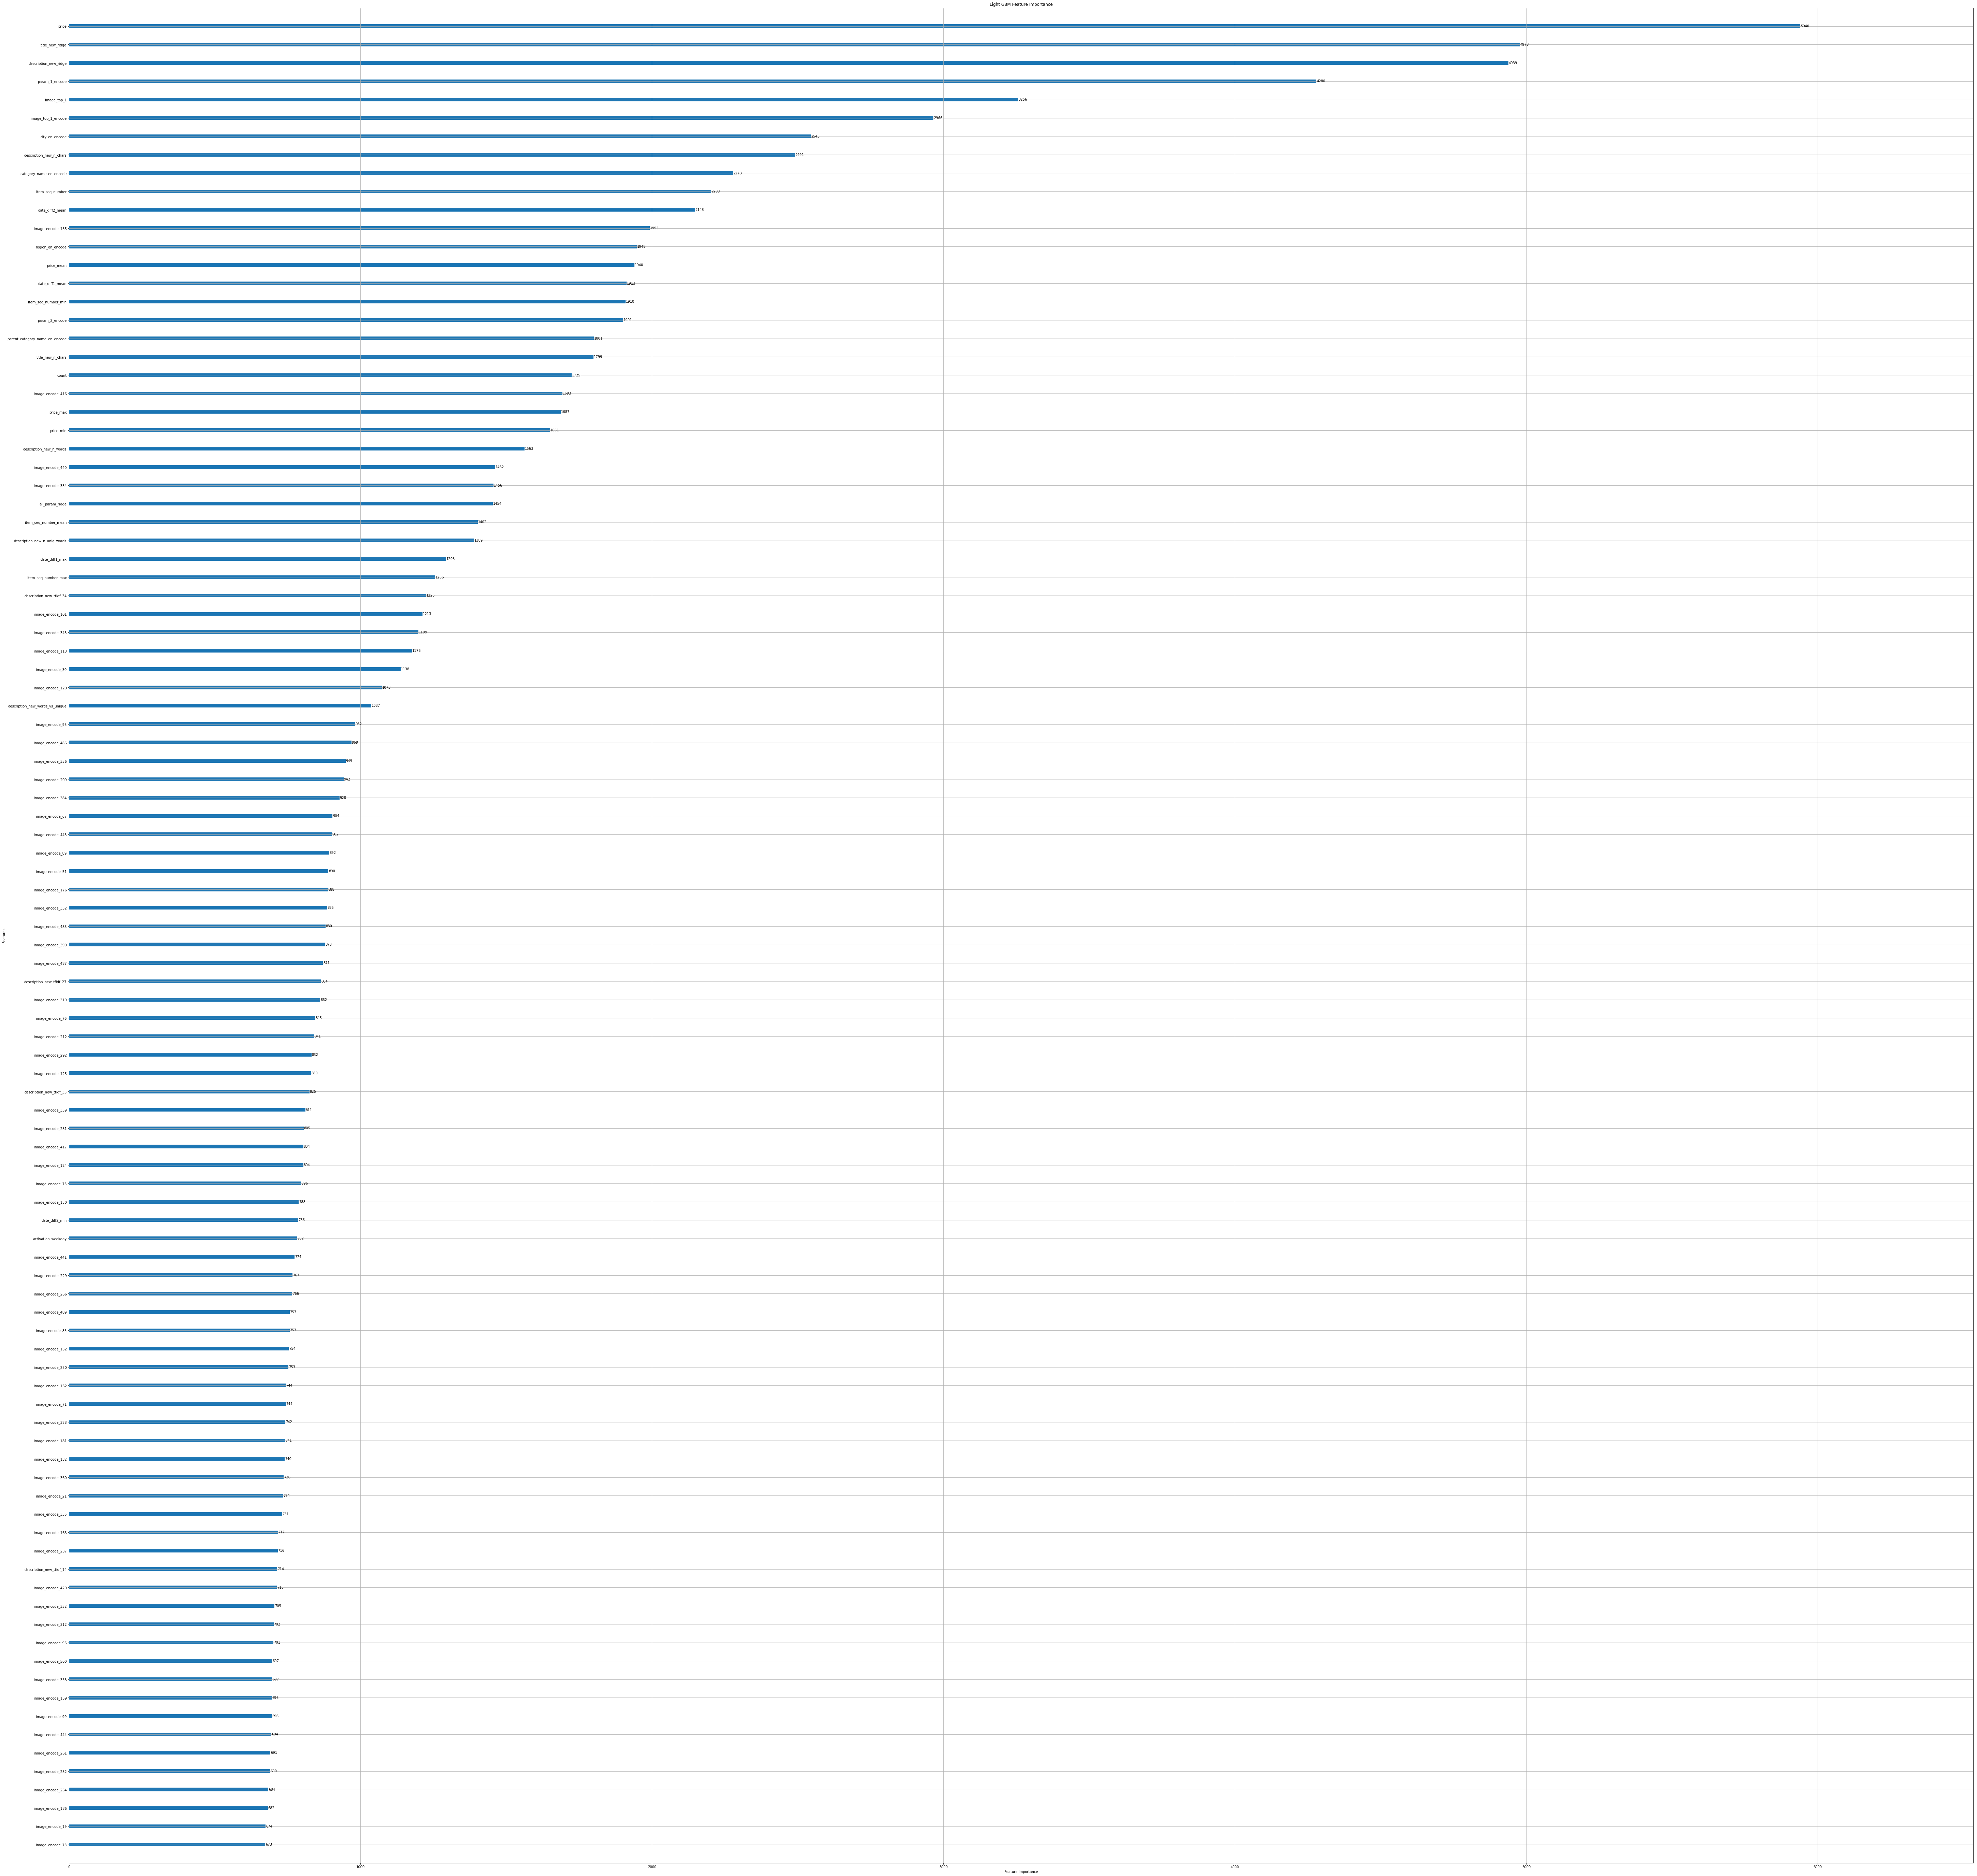

In [115]:
## Feature Importance
f, ax = plt.subplots(figsize=[100,100])
lgb.plot_importance(gbm, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

### XGBoost Training

Though XGBoost takes a lot of time to find the best solution, it can improve accuracy of prediction and help reduce the loss.

In [119]:
## Set datasets for training, validation and test
xgb_train = xgb.DMatrix(X_train, label = y_train)
xgb_val = xgb.DMatrix(X_valid, label = y_valid)
xgb_test=xgb.DMatrix(X_test)

In [120]:
## Set parameters
params = {'booster':'gbtree', 'objective': 'reg:linear', 'gamma':0.1, 'max_depth':12, 'lambda':2, 'subsample':0.7, 
          'colsample_bytree':0.7, 'min_child_weight':3, 'silent':0 , 'eta': 0.007, 'seed':12345, 'eval_metric': 'rmse'}

In [121]:
## Training model
plst = list(params.items())
num_rounds = 10000
watchlist = [(xgb_train, 'train'),(xgb_val, 'val')]
model = xgb.train(plst, xgb_train, num_rounds, watchlist,early_stopping_rounds = 50)
model.save_model('xgb.model')
print("best best_ntree_limit",model.best_ntree_limit)
preds = model.predict(xgb_test,ntree_limit=model.best_ntree_limit)

[0]	train-rmse:0.4425	val-rmse:0.442601
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.440219	val-rmse:0.440336
[2]	train-rmse:0.437977	val-rmse:0.438125
[3]	train-rmse:0.435771	val-rmse:0.43597
[4]	train-rmse:0.433534	val-rmse:0.433752
[5]	train-rmse:0.431339	val-rmse:0.431578
[6]	train-rmse:0.429141	val-rmse:0.429415
[7]	train-rmse:0.426962	val-rmse:0.427272
[8]	train-rmse:0.424803	val-rmse:0.425135
[9]	train-rmse:0.42267	val-rmse:0.423035
[10]	train-rmse:0.420578	val-rmse:0.420977
[11]	train-rmse:0.418476	val-rmse:0.418899
[12]	train-rmse:0.41642	val-rmse:0.416883
[13]	train-rmse:0.414409	val-rmse:0.414879
[14]	train-rmse:0.412371	val-rmse:0.412865
[15]	train-rmse:0.410365	val-rmse:0.41088
[16]	train-rmse:0.408352	val-rmse:0.408891
[17]	train-rmse:0.406383	val-rmse:0.406963
[18]	train-rmse:0.404403	val-rmse:0.405015
[19]	train-rmse:0.402465	val-rmse:0.403104
[20]	train-rmse

[187]	train-rmse:0.24206	val-rmse:0.249048
[188]	train-rmse:0.24172	val-rmse:0.248747
[189]	train-rmse:0.241382	val-rmse:0.248452
[190]	train-rmse:0.241045	val-rmse:0.248155
[191]	train-rmse:0.240707	val-rmse:0.247863
[192]	train-rmse:0.240379	val-rmse:0.24757
[193]	train-rmse:0.240052	val-rmse:0.247277
[194]	train-rmse:0.239729	val-rmse:0.24699
[195]	train-rmse:0.239407	val-rmse:0.246721
[196]	train-rmse:0.239088	val-rmse:0.246442
[197]	train-rmse:0.238788	val-rmse:0.246166
[198]	train-rmse:0.238483	val-rmse:0.245896
[199]	train-rmse:0.238179	val-rmse:0.245628
[200]	train-rmse:0.237874	val-rmse:0.245369
[201]	train-rmse:0.237586	val-rmse:0.245115
[202]	train-rmse:0.237286	val-rmse:0.244856
[203]	train-rmse:0.236986	val-rmse:0.244595
[204]	train-rmse:0.236691	val-rmse:0.244343
[205]	train-rmse:0.236404	val-rmse:0.24409
[206]	train-rmse:0.236126	val-rmse:0.243853
[207]	train-rmse:0.23585	val-rmse:0.243618
[208]	train-rmse:0.235583	val-rmse:0.243384
[209]	train-rmse:0.2353	val-rmse:0.243

[375]	train-rmse:0.213439	val-rmse:0.226776
[376]	train-rmse:0.213375	val-rmse:0.226742
[377]	train-rmse:0.213314	val-rmse:0.22671
[378]	train-rmse:0.213262	val-rmse:0.226685
[379]	train-rmse:0.2132	val-rmse:0.226654
[380]	train-rmse:0.213135	val-rmse:0.226621
[381]	train-rmse:0.213083	val-rmse:0.226594
[382]	train-rmse:0.213028	val-rmse:0.226565
[383]	train-rmse:0.212974	val-rmse:0.226535
[384]	train-rmse:0.212916	val-rmse:0.226508
[385]	train-rmse:0.212853	val-rmse:0.22648
[386]	train-rmse:0.212793	val-rmse:0.226451
[387]	train-rmse:0.212735	val-rmse:0.226422
[388]	train-rmse:0.212678	val-rmse:0.226394
[389]	train-rmse:0.21262	val-rmse:0.226366
[390]	train-rmse:0.212565	val-rmse:0.226338
[391]	train-rmse:0.212503	val-rmse:0.22631
[392]	train-rmse:0.212446	val-rmse:0.226282
[393]	train-rmse:0.212391	val-rmse:0.226256
[394]	train-rmse:0.212336	val-rmse:0.226231
[395]	train-rmse:0.212291	val-rmse:0.22621
[396]	train-rmse:0.212241	val-rmse:0.226185
[397]	train-rmse:0.212194	val-rmse:0.22

[562]	train-rmse:0.206341	val-rmse:0.22428
[563]	train-rmse:0.206312	val-rmse:0.224275
[564]	train-rmse:0.206283	val-rmse:0.22427
[565]	train-rmse:0.206257	val-rmse:0.224265
[566]	train-rmse:0.206234	val-rmse:0.224261
[567]	train-rmse:0.206209	val-rmse:0.224256
[568]	train-rmse:0.206182	val-rmse:0.224252
[569]	train-rmse:0.206163	val-rmse:0.224249
[570]	train-rmse:0.206139	val-rmse:0.224245
[571]	train-rmse:0.206121	val-rmse:0.224242
[572]	train-rmse:0.206099	val-rmse:0.224238
[573]	train-rmse:0.206074	val-rmse:0.224235
[574]	train-rmse:0.206054	val-rmse:0.224231
[575]	train-rmse:0.206028	val-rmse:0.224227
[576]	train-rmse:0.206002	val-rmse:0.224223
[577]	train-rmse:0.205979	val-rmse:0.224222
[578]	train-rmse:0.205955	val-rmse:0.224216
[579]	train-rmse:0.205933	val-rmse:0.224213
[580]	train-rmse:0.205909	val-rmse:0.224213
[581]	train-rmse:0.20589	val-rmse:0.22421
[582]	train-rmse:0.205867	val-rmse:0.224207
[583]	train-rmse:0.205842	val-rmse:0.224204
[584]	train-rmse:0.205817	val-rmse:0

[749]	train-rmse:0.202656	val-rmse:0.223758
[750]	train-rmse:0.202641	val-rmse:0.223757
[751]	train-rmse:0.202626	val-rmse:0.223756
[752]	train-rmse:0.202616	val-rmse:0.223754
[753]	train-rmse:0.2026	val-rmse:0.223752
[754]	train-rmse:0.202585	val-rmse:0.22375
[755]	train-rmse:0.202565	val-rmse:0.223748
[756]	train-rmse:0.20255	val-rmse:0.223746
[757]	train-rmse:0.202537	val-rmse:0.223745
[758]	train-rmse:0.202518	val-rmse:0.223743
[759]	train-rmse:0.202497	val-rmse:0.22374
[760]	train-rmse:0.202478	val-rmse:0.223738
[761]	train-rmse:0.202464	val-rmse:0.223737
[762]	train-rmse:0.202452	val-rmse:0.223736
[763]	train-rmse:0.202439	val-rmse:0.223733
[764]	train-rmse:0.202423	val-rmse:0.223732
[765]	train-rmse:0.202412	val-rmse:0.22373
[766]	train-rmse:0.2024	val-rmse:0.223728
[767]	train-rmse:0.202388	val-rmse:0.223727
[768]	train-rmse:0.202376	val-rmse:0.223725
[769]	train-rmse:0.202359	val-rmse:0.223724
[770]	train-rmse:0.202351	val-rmse:0.223724
[771]	train-rmse:0.202329	val-rmse:0.223

[937]	train-rmse:0.199906	val-rmse:0.223492
[938]	train-rmse:0.199894	val-rmse:0.22349
[939]	train-rmse:0.199881	val-rmse:0.223489
[940]	train-rmse:0.19987	val-rmse:0.223488
[941]	train-rmse:0.199856	val-rmse:0.223488
[942]	train-rmse:0.199846	val-rmse:0.223488
[943]	train-rmse:0.199836	val-rmse:0.223488
[944]	train-rmse:0.199825	val-rmse:0.223487
[945]	train-rmse:0.199815	val-rmse:0.223486
[946]	train-rmse:0.199805	val-rmse:0.223486
[947]	train-rmse:0.199796	val-rmse:0.223485
[948]	train-rmse:0.199777	val-rmse:0.223483
[949]	train-rmse:0.199762	val-rmse:0.223482
[950]	train-rmse:0.199752	val-rmse:0.223481
[951]	train-rmse:0.199739	val-rmse:0.223478
[952]	train-rmse:0.19973	val-rmse:0.223477
[953]	train-rmse:0.199718	val-rmse:0.223474
[954]	train-rmse:0.199705	val-rmse:0.223472
[955]	train-rmse:0.199695	val-rmse:0.223471
[956]	train-rmse:0.199684	val-rmse:0.223471
[957]	train-rmse:0.199653	val-rmse:0.223465
[958]	train-rmse:0.199639	val-rmse:0.223463
[959]	train-rmse:0.199628	val-rmse:

[1122]	train-rmse:0.197855	val-rmse:0.22332
[1123]	train-rmse:0.197847	val-rmse:0.223319
[1124]	train-rmse:0.197825	val-rmse:0.223318
[1125]	train-rmse:0.197812	val-rmse:0.223318
[1126]	train-rmse:0.197802	val-rmse:0.223318
[1127]	train-rmse:0.197797	val-rmse:0.223317
[1128]	train-rmse:0.197791	val-rmse:0.223318
[1129]	train-rmse:0.197781	val-rmse:0.223317
[1130]	train-rmse:0.19777	val-rmse:0.223316
[1131]	train-rmse:0.19776	val-rmse:0.223316
[1132]	train-rmse:0.19775	val-rmse:0.223316
[1133]	train-rmse:0.197743	val-rmse:0.223316
[1134]	train-rmse:0.197726	val-rmse:0.223317
[1135]	train-rmse:0.197716	val-rmse:0.223315
[1136]	train-rmse:0.197702	val-rmse:0.223315
[1137]	train-rmse:0.197694	val-rmse:0.223314
[1138]	train-rmse:0.197681	val-rmse:0.223313
[1139]	train-rmse:0.197675	val-rmse:0.223313
[1140]	train-rmse:0.197664	val-rmse:0.223313
[1141]	train-rmse:0.19765	val-rmse:0.223313
[1142]	train-rmse:0.197639	val-rmse:0.223312
[1143]	train-rmse:0.197631	val-rmse:0.223311
[1144]	train-rm

[1305]	train-rmse:0.196119	val-rmse:0.223218
[1306]	train-rmse:0.196107	val-rmse:0.223217
[1307]	train-rmse:0.196098	val-rmse:0.223216
[1308]	train-rmse:0.19609	val-rmse:0.223216
[1309]	train-rmse:0.196082	val-rmse:0.223215
[1310]	train-rmse:0.196076	val-rmse:0.223215
[1311]	train-rmse:0.196068	val-rmse:0.223214
[1312]	train-rmse:0.196064	val-rmse:0.223214
[1313]	train-rmse:0.196056	val-rmse:0.223214
[1314]	train-rmse:0.19605	val-rmse:0.223214
[1315]	train-rmse:0.196043	val-rmse:0.223213
[1316]	train-rmse:0.196037	val-rmse:0.223213
[1317]	train-rmse:0.19603	val-rmse:0.223213
[1318]	train-rmse:0.196022	val-rmse:0.223212
[1319]	train-rmse:0.196015	val-rmse:0.223212
[1320]	train-rmse:0.196005	val-rmse:0.223212
[1321]	train-rmse:0.195994	val-rmse:0.223212
[1322]	train-rmse:0.195988	val-rmse:0.223212
[1323]	train-rmse:0.195983	val-rmse:0.22321
[1324]	train-rmse:0.195978	val-rmse:0.22321
[1325]	train-rmse:0.195971	val-rmse:0.22321
[1326]	train-rmse:0.195961	val-rmse:0.223211
[1327]	train-rms

[1488]	train-rmse:0.19458	val-rmse:0.223143
[1489]	train-rmse:0.194574	val-rmse:0.223143
[1490]	train-rmse:0.194559	val-rmse:0.223141
[1491]	train-rmse:0.19455	val-rmse:0.223142
[1492]	train-rmse:0.194542	val-rmse:0.223142
[1493]	train-rmse:0.194532	val-rmse:0.223141
[1494]	train-rmse:0.194529	val-rmse:0.223141
[1495]	train-rmse:0.194521	val-rmse:0.223141
[1496]	train-rmse:0.194511	val-rmse:0.223141
[1497]	train-rmse:0.194504	val-rmse:0.223141
[1498]	train-rmse:0.194498	val-rmse:0.22314
[1499]	train-rmse:0.194491	val-rmse:0.22314
[1500]	train-rmse:0.194485	val-rmse:0.22314
[1501]	train-rmse:0.194476	val-rmse:0.22314
[1502]	train-rmse:0.194471	val-rmse:0.223139
[1503]	train-rmse:0.194468	val-rmse:0.223139
[1504]	train-rmse:0.194461	val-rmse:0.223138
[1505]	train-rmse:0.194455	val-rmse:0.223138
[1506]	train-rmse:0.194446	val-rmse:0.223137
[1507]	train-rmse:0.194436	val-rmse:0.223136
[1508]	train-rmse:0.194424	val-rmse:0.223135
[1509]	train-rmse:0.194416	val-rmse:0.223135
[1510]	train-rms

[1672]	train-rmse:0.193189	val-rmse:0.223085
[1673]	train-rmse:0.193186	val-rmse:0.223085
[1674]	train-rmse:0.193178	val-rmse:0.223085
[1675]	train-rmse:0.193171	val-rmse:0.223084
[1676]	train-rmse:0.193165	val-rmse:0.223083
[1677]	train-rmse:0.19316	val-rmse:0.223083
[1678]	train-rmse:0.193152	val-rmse:0.223083
[1679]	train-rmse:0.193144	val-rmse:0.223085
[1680]	train-rmse:0.19314	val-rmse:0.223085
[1681]	train-rmse:0.193134	val-rmse:0.223084
[1682]	train-rmse:0.193127	val-rmse:0.223084
[1683]	train-rmse:0.19312	val-rmse:0.223083
[1684]	train-rmse:0.19311	val-rmse:0.223083
[1685]	train-rmse:0.193099	val-rmse:0.223082
[1686]	train-rmse:0.19309	val-rmse:0.223082
[1687]	train-rmse:0.193085	val-rmse:0.223082
[1688]	train-rmse:0.193076	val-rmse:0.223085
[1689]	train-rmse:0.193066	val-rmse:0.223084
[1690]	train-rmse:0.193061	val-rmse:0.223084
[1691]	train-rmse:0.193052	val-rmse:0.223084
[1692]	train-rmse:0.193047	val-rmse:0.223083
[1693]	train-rmse:0.193041	val-rmse:0.223083
[1694]	train-rm

[1855]	train-rmse:0.191854	val-rmse:0.223037
[1856]	train-rmse:0.191848	val-rmse:0.223036
[1857]	train-rmse:0.191836	val-rmse:0.223034
[1858]	train-rmse:0.191828	val-rmse:0.223035
[1859]	train-rmse:0.19182	val-rmse:0.223034
[1860]	train-rmse:0.191814	val-rmse:0.223034
[1861]	train-rmse:0.191806	val-rmse:0.223034
[1862]	train-rmse:0.191801	val-rmse:0.223033
[1863]	train-rmse:0.191795	val-rmse:0.223033
[1864]	train-rmse:0.19179	val-rmse:0.223033
[1865]	train-rmse:0.191781	val-rmse:0.223032
[1866]	train-rmse:0.191766	val-rmse:0.223031
[1867]	train-rmse:0.191761	val-rmse:0.223031
[1868]	train-rmse:0.191757	val-rmse:0.22303
[1869]	train-rmse:0.191751	val-rmse:0.22303
[1870]	train-rmse:0.191744	val-rmse:0.22303
[1871]	train-rmse:0.191738	val-rmse:0.22303
[1872]	train-rmse:0.191729	val-rmse:0.223029
[1873]	train-rmse:0.191722	val-rmse:0.223029
[1874]	train-rmse:0.191711	val-rmse:0.223028
[1875]	train-rmse:0.191704	val-rmse:0.223027
[1876]	train-rmse:0.191699	val-rmse:0.223027
[1877]	train-rms

[2040]	train-rmse:0.190605	val-rmse:0.222997
[2041]	train-rmse:0.1906	val-rmse:0.222997
[2042]	train-rmse:0.190592	val-rmse:0.222998
[2043]	train-rmse:0.190586	val-rmse:0.222997
[2044]	train-rmse:0.190581	val-rmse:0.222997
[2045]	train-rmse:0.190574	val-rmse:0.222997
[2046]	train-rmse:0.190571	val-rmse:0.222997
[2047]	train-rmse:0.190563	val-rmse:0.222996
[2048]	train-rmse:0.190555	val-rmse:0.222996
[2049]	train-rmse:0.190551	val-rmse:0.222996
[2050]	train-rmse:0.190543	val-rmse:0.222995
[2051]	train-rmse:0.190538	val-rmse:0.222995
[2052]	train-rmse:0.190533	val-rmse:0.222995
[2053]	train-rmse:0.190524	val-rmse:0.222994
[2054]	train-rmse:0.190518	val-rmse:0.222993
[2055]	train-rmse:0.190511	val-rmse:0.222993
[2056]	train-rmse:0.190504	val-rmse:0.222992
[2057]	train-rmse:0.190497	val-rmse:0.222992
[2058]	train-rmse:0.190492	val-rmse:0.222992
[2059]	train-rmse:0.190488	val-rmse:0.222992
[2060]	train-rmse:0.190482	val-rmse:0.222991
[2061]	train-rmse:0.190475	val-rmse:0.222992
[2062]	train

[2223]	train-rmse:0.189434	val-rmse:0.222953
[2224]	train-rmse:0.189425	val-rmse:0.222952
[2225]	train-rmse:0.18942	val-rmse:0.222953
[2226]	train-rmse:0.189417	val-rmse:0.222953
[2227]	train-rmse:0.189411	val-rmse:0.222953
[2228]	train-rmse:0.189397	val-rmse:0.222951
[2229]	train-rmse:0.189391	val-rmse:0.222952
[2230]	train-rmse:0.189387	val-rmse:0.222952
[2231]	train-rmse:0.189382	val-rmse:0.222952
[2232]	train-rmse:0.189375	val-rmse:0.222952
[2233]	train-rmse:0.189369	val-rmse:0.222952
[2234]	train-rmse:0.189359	val-rmse:0.222951
[2235]	train-rmse:0.189355	val-rmse:0.222951
[2236]	train-rmse:0.189352	val-rmse:0.22295
[2237]	train-rmse:0.189345	val-rmse:0.22295
[2238]	train-rmse:0.189339	val-rmse:0.22295
[2239]	train-rmse:0.189326	val-rmse:0.222949
[2240]	train-rmse:0.189322	val-rmse:0.222949
[2241]	train-rmse:0.1893	val-rmse:0.222946
[2242]	train-rmse:0.189296	val-rmse:0.222946
[2243]	train-rmse:0.189292	val-rmse:0.222946
[2244]	train-rmse:0.189287	val-rmse:0.222946
[2245]	train-rms

[2407]	train-rmse:0.188273	val-rmse:0.222918
[2408]	train-rmse:0.188269	val-rmse:0.222918
[2409]	train-rmse:0.188263	val-rmse:0.222918
[2410]	train-rmse:0.188255	val-rmse:0.222917
[2411]	train-rmse:0.188247	val-rmse:0.222917
[2412]	train-rmse:0.188233	val-rmse:0.222916
[2413]	train-rmse:0.188224	val-rmse:0.222916
[2414]	train-rmse:0.18822	val-rmse:0.222916
[2415]	train-rmse:0.188209	val-rmse:0.222916
[2416]	train-rmse:0.188203	val-rmse:0.222916
[2417]	train-rmse:0.188198	val-rmse:0.222916
[2418]	train-rmse:0.188194	val-rmse:0.222916
[2419]	train-rmse:0.18819	val-rmse:0.222915
[2420]	train-rmse:0.188182	val-rmse:0.222915
[2421]	train-rmse:0.188169	val-rmse:0.222916
[2422]	train-rmse:0.188167	val-rmse:0.222916
[2423]	train-rmse:0.188163	val-rmse:0.222915
[2424]	train-rmse:0.188157	val-rmse:0.222915
[2425]	train-rmse:0.188153	val-rmse:0.222915
[2426]	train-rmse:0.188142	val-rmse:0.222915
[2427]	train-rmse:0.188139	val-rmse:0.222915
[2428]	train-rmse:0.188134	val-rmse:0.222914
[2429]	train

In [122]:
## Predict with trained model
y_pred = model.predict(xgb_train)
y_pred_valid = model.predict(xgb_val)
y_pred_test = model.predict(xgb_test)

In [123]:
## Create datasets for prediction
pred_train = pd.DataFrame(y_pred)
pred_train.columns = ['y_pred']
pred_valid = pd.DataFrame(y_pred_valid)
pred_valid.columns = ['y_pred_valid']
pred_test = pd.DataFrame(y_pred_test)
pred_test.columns = ['y_pred_test']

In [124]:
## Create datasets for actual results
actual_train = pd.DataFrame(y_train)
actual_train.columns = ['actual_train']
actual_valid = pd.DataFrame(y_valid)
actual_valid.columns = ['actual_valid']

In [125]:
## Calculate RMSE
train_rmse = mean_squared_error(actual_train['actual_train'], pred_train['y_pred']) ** 0.5
print("RMSE of training data is ", train_rmse)
valid_rmse = mean_squared_error(actual_valid['actual_valid'], pred_valid['y_pred_valid']) ** 0.5
print("RMSE of validation data is ", valid_rmse)

RMSE of training data is  0.18734927578316696
RMSE of validation data is  0.2229020412393488


### Submission and Results

XGBoost model outperforms Light GBM model slightly so we take the result of XGBoost as our final submission.

In [126]:
pred_test['y_pred_test'] = pred_test['y_pred_test'].apply(lambda x: 0 if x < 0 else (1 if x > 1 else x))

In [127]:
submission = pd.DataFrame()
submission['item_id'] = test['item_id']
submission['deal_probability'] = pred_test['y_pred_test']
submission = submission.set_index('item_id')

In [128]:
submission.to_csv('submission.csv')

This **leaderboard** is calculated with approximately 31% of the test data. Our score is **0.2249** and is ranked at **1164/1917**.

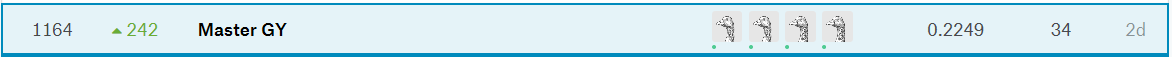

The **final results** will be based on the other 69%, so the final standings may be different. Our score is **0.2290** and is ranked at **1202/1917**.

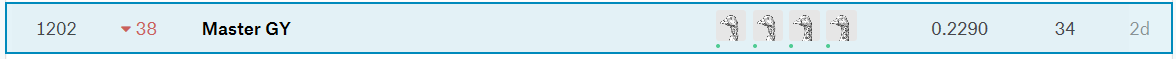